# CIFAR10 Classifier

This notebook prepares an CIFAR10 classifier using a Convolutional Neural Network (CNN)

In [1]:
# import required libs
import keras
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import preprocess_input, decode_predictions

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

%matplotlib inline

Using TensorFlow backend.


Set Parameters

In [2]:
batch_size = 128
num_classes = 10
epochs = 10
input_shape = (32, 32, 3)

## Get CIFAR Dataset

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Dataset Details

In [4]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Build a CNN based deep neural network

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Visualize the network architecture

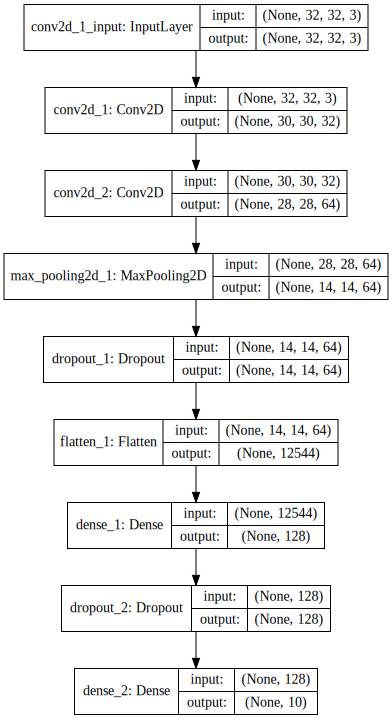

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

## Compile the model

In [8]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Train the classifier

In [9]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/10
50000/50000 [==============================] - 256s - loss: 7.3118 - acc: 0.1798   
Epoch 2/10
50000/50000 [==============================] - 250s - loss: 1.7923 - acc: 0.3564   
Epoch 3/10
50000/50000 [==============================] - 252s - loss: 1.5781 - acc: 0.4383   
Epoch 4/10
50000/50000 [==============================] - 251s - loss: 1.4506 - acc: 0.4893   
Epoch 5/10
50000/50000 [==============================] - 252s - loss: 1.3528 - acc: 0.5215   
Epoch 6/10
50000/50000 [==============================] - 250s - loss: 1.2717 - acc: 0.5502   
Epoch 7/10
50000/50000 [==============================] - 252s - loss: 1.2059 - acc: 0.5770   
Epoch 8/10
50000/50000 [==============================] - 254s - loss: 1.1565 - acc: 0.5948   
Epoch 9/10
50000/50000 [==============================] - 251s - loss: 1.1019 - acc: 0.6163   
Epoch 10/10
50000/50000 [==============================] - 254s - loss: 1.0584 - acc: 0.6284   


## Predict and test model performance

In [10]:
score = model.evaluate(x_test, y_test, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

In [11]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.10143025074
Test accuracy: 0.6354


# How CNN Classifies an Image? 

Prepare image for CNN

In [12]:
img_idx = 999

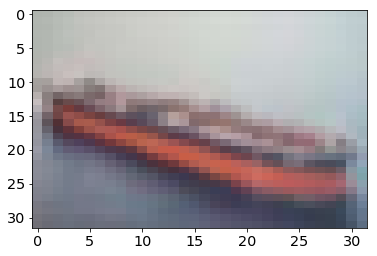

In [13]:
plt.imshow(x_test[img_idx],aspect='auto')

Image Label

In [14]:
y_test[img_idx]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

Predict the label

In [15]:
test_image =np.expand_dims(x_test[img_idx], axis=0)
test_image.shape

(1, 32, 32, 3)

In [16]:
model.predict_classes(test_image,batch_size=1)

1/1 [==============================] - 0s


array([8], dtype=int64)

In [17]:
model.predict_proba(test_image,batch_size=1)

1/1 [==============================] - 0s


array([[  6.37772540e-03,   1.83971148e-04,   8.36352046e-06,
          1.32570420e-07,   3.34822033e-07,   4.82157869e-09,
          4.56026505e-08,   4.81511553e-10,   9.93404567e-01,
          2.48477136e-05]], dtype=float32)

## Utility Methods to understand CNN
+ source: https://github.com/fchollet/keras/issues/431
+ source: https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py

In [18]:
# https://github.com/fchollet/keras/issues/431
def get_activations(model, model_inputs, print_shape_only=True, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [19]:
# https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        #plt.imshow(activations, interpolation='None', cmap='binary')
        fig, ax = plt.subplots(figsize=(18, 12))
        ax.imshow(activations, interpolation='None', cmap='binary')
        plt.show()

In [20]:
activations = get_activations(model, test_image)

----- activations -----
(1, 30, 30, 32)
(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 14, 14, 64)
(1, 12544)
(1, 128)
(1, 128)
(1, 10)


Displaying activation map 0


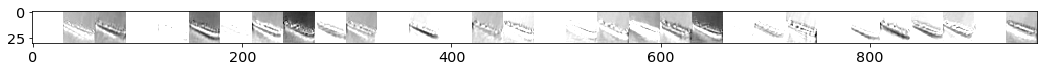

Displaying activation map 1


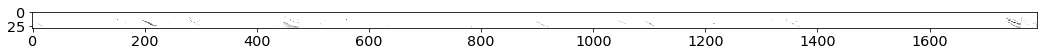

Displaying activation map 2


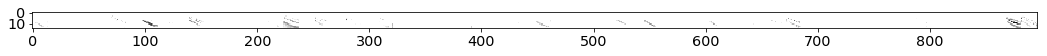

Displaying activation map 3


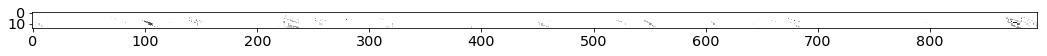

Displaying activation map 4


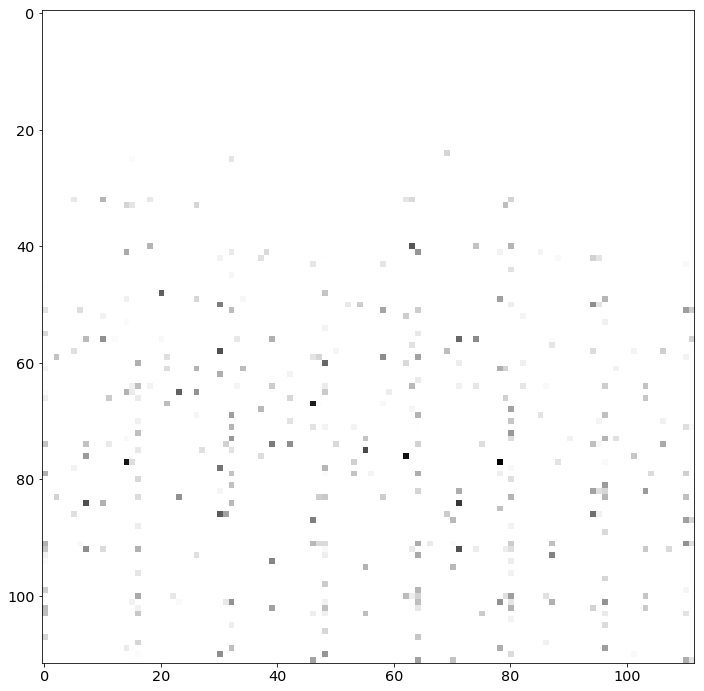

Displaying activation map 5


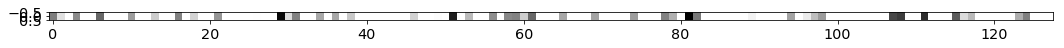

Displaying activation map 6


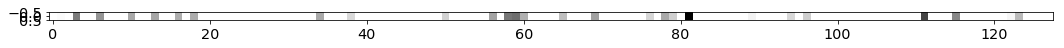

Displaying activation map 7


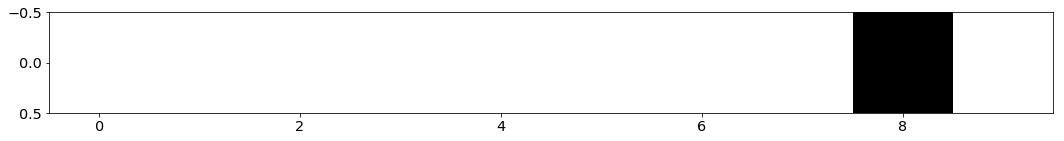

In [21]:
display_activations(activations)